# Elevator Up

## Introduction

Although there is much we still don't know about SARS-CoV-2, the virus which causes COVID-19, there is <a href="https://www.businessinsider.com/coronavirus-jumped-between-people-via-elevator-surfaces-study-2020-7">evidence to suggest</a> that the virus can <a href="https://www.businessinsider.com/how-to-lower-coronavirus-risk-riding-elevator-office-2020-6">remain on surfaces such as elevator buttons</a> long enough for community spread to occur. As the world <a href="https://www.ibtimes.sg/how-reduce-usage-elevator-buttons-amid-coronavirus-scare-these-creative-ideas-might-help-you-40926">searches for a way</a> to reduce physical interactions with elevator buttons, a viable option is turning to <b>voice control</b>.

In this project, we will train a neural network to recognize the digit being spoken in a short audio recording. Once trained, this model could be deployed in an inexpensive microcontroller (such as a Raspberry Pi or Arduino), then retrofitted onto existing elevators to augment the control scheme. It would serve as a first-line option to provide a contactless option for elevator control, while the existing buttons could remain functional for people with speech impairments or as an override for misclassifications.

## What's in This Notebook

This notebook compares four neural networks. The first three consist of a single input layer, a fully-connected hidden layer with 256 units, and an output layer:

The first network trains on the raw, unprocessed (other than downsampling) audio data.

The second  network trains on the time-averaged absolute value of STFT bins.

The third network that trains on the (flattened) MFCCs.

The fourth network places a `Conv1D` layer and `Flatten` layer before the dense layer.

To keep things straightforward and consistent, we'll be comparing the performance of these four different approaches with the accuracy score on the validation data.

## Data

If you have not already downloaded and extracted the <a href="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz">Speech Commands Dataset</a>, the cell below will do this for you.

This dataset was curated by TensorFlow and AIY specifically for machine learning projects to have access to a large number of short clips featuring specific words. In particular, we will be using the words "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", and "nine". Feel free to delete the directories for the other words if you have storage limitations on your computer, but make sure to leave the digits in-tact for this notebook.

In [21]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speech_commands_v0.01

import tarfile
tar = tarfile.open('speech_commands_v0.01.tar.gz')
tar.extractall(path='speech_commands_v0.01/')
tar.close()

--2020-08-31 08:49:08--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4004:809::2010, 172.217.9.208
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4004:809::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  27.7MB/s    in 53s     

2020-08-31 08:50:00 (27.0 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



## Metadata

First, we need to generate our metadata. This will allow for much faster loading down the line, because we can train_test_split on the metadata instead of the raw data, then load only the data in our training set. The function below needs to be called only one time, and not at all if you've downloaded `metadata.csv`.

In [4]:
import os
import librosa
import tqdm
import pandas as pd

def generate_metadata(dirname='speech_commands_v0.01', 
                      separator='/', 
                      metadata_filename='metadata.csv'):
    """
    Function to generate metadata, if you haven't downloaded metadata.csv. Consists of:
    
    filename: the path from this notebook's directory to the audio file in question.
    rec_id: hash code for the filename, which serves as an int index. 
    digit: the name of the digit being spoken (which is the name of the subdirectory
           containing the file)
    length: the length of the file, in number of samples at a sampling rate of 8000
    
    Saves all metadata in the file metadata_filename. If you've downloaded metadata.csv, 
    there is no need to run this function.
    
    This function does not return anything. 
    
    ==========================================================================================
    
    Parameters
    ----------
    dirname (str): 
        The name of the directory containing the speech commands. 
        Default: 'speech_commands_v0.01'
        
    separator (str):
        Delimiting character for the filepath.
        Default: '/'
        
    metadata_filename (str):
        The name of the file where metadata will be stored. If extension '.csv'
        is not specified, '.csv' will be appended.
        Default: 'metadata.csv'
        
    ==========================================================================================
    
    Returns
    -------
    None
    """

    # these are the digits we're working with, which also have to 
    digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

    # generate the name of each file
    filenames = [dirname 
                 + separator 
                 + digit 
                 + separator 
                 + filename 
                 for digit in digits for filename in os.listdir(dirname + '/' + digit)]

    # check to make sure that the number of unique hash codes matches the number of unique filenames.
    # in other words, each recording can be identified uniquely by 
    assert len(filenames) == len(set(hash(filename) for filename in filenames)), 'colliding hash codes'

    # generate the metadata for each of the files.
    # metadata includes:
    #   filename: the complete path to the file from the root directory
    #   rec_id: the hash code for that particular filename
    #   digit: the name of the digit spoken in the recording
    #   length: the length of the recording, when sampled at 8000 Hz
    metadata = [{'filename':filename, 
                 'rec_id':hash(filename), 
                 'digit':filename.split(separator)[1],
                 'length':len(librosa.load(filename, sr=8000)[0])} for filename in tqdm.tqdm(filenames)]

    # append extension if it is not already specified
    if not metadata_filename.endswith('.csv'):
        metadata_filename += '.csv'
    
    # create dictionary from the metadata
    # create DataFrame from metadata with columns in consistent order
    # save DataFrame as a csv with name metadata_filename
    pd.DataFrame.from_dict(metadata)[['filename', 'rec_id', 'digit', 'length']].to_csv(metadata_filename)
    
#generate_metadata()

## Exploratory Data Analysis

Now that we have a scheme for loading the data, let's explore it a little bit to familiarize ourselves with its properties. We'll continue to explore the data throughout this notebook, but first we want to make sure there aren't any major class imbalance issues and take a peek at what each observation actually looks like.

Class | Percent of Observations
-------------------------------
0     | 10.2%
1     | 9.8%
2     | 9.9%
3     | 9.9%
4     | 10.0%
5     | 10.0%
6     | 10.2%
7     | 10.1%
8     | 9.8%
9     | 10.1%


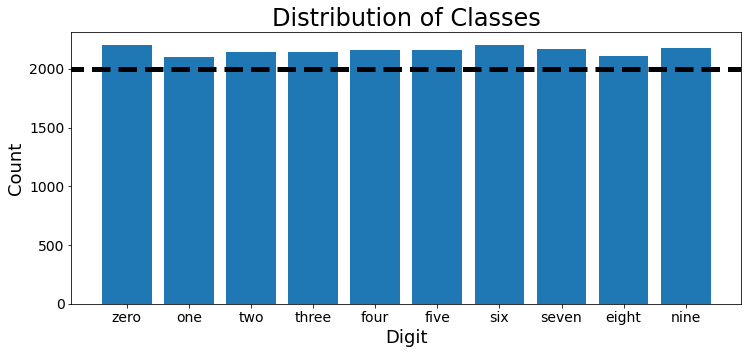

In [20]:
import data_loader
digits = data_loader.digit_names

# mdf for metaDataFrame
mdf = pd.read_csv('metadata.csv')

# keep only the recordings that are exactly one second long
mdf = mdf[mdf.length == 8000]

# to keep track of the number of observations in each class
num_observations = []

for digit in digits:
    # add the number of observations for that class
    num_observations.append(mdf[mdf.digit == digit].shape[0])
    
percents = [100 * obs / mdf.shape[0] for obs in num_observations]
print('Class | Percent of Observations')
print('-------------------------------')
for i, percent in enumerate(percents):
    print(i, '    |', '{:.1f}%'.format(percent))

plt.figure(figsize=(12,5))
plt.hlines(y=2000, xmin=-1, xmax=10, color='black', linestyle='--', linewidth=5)
plt.bar(x=digits, height=num_observations)
plt.xlabel('Digit', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.tick_params(labelsize=14)
plt.title('Distribution of Classes', fontsize=24)

plt.show()

As we can see, there are no major imbalance issues in the dataset. All classes have over least two thousand observations, and no class deviates from 10% by more than about 0.2%.

Next, let's see what individual observations look like.

Data preview: [-7.1878421e-06  1.2942923e-04  2.2852169e-04  1.7629229e-04
  1.4636852e-04  6.2292398e-05  7.5088123e-05  1.9000929e-04
  2.7936997e-04  2.5223594e-04]

Data summary:
count    8000.000000
mean       -0.000080
std         0.088220
min        -0.740665
25%        -0.000605
50%         0.000021
75%         0.000866
max         0.581453
dtype: float64


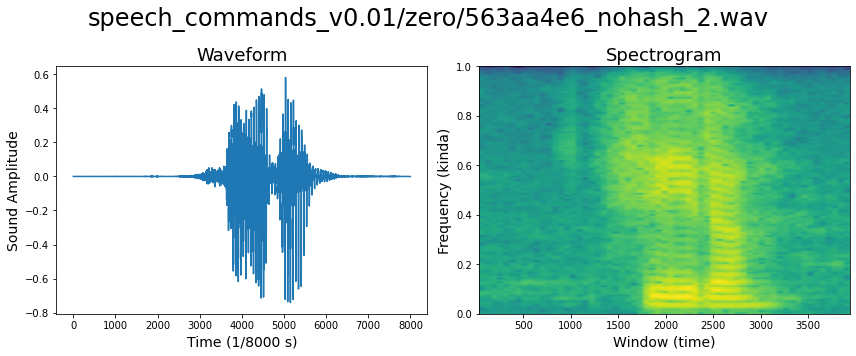

In [44]:
import librosa
import pandas as pd
import matplotlib.pyplot as plt

x, sr = librosa.load(mdf.iloc[7]['filename'], sr=8000)

print('Data preview:', x[:10])
print('\nData summary:')
print(pd.Series(x).describe())

fig, (waveform, specgram) = plt.subplots(1,2, figsize=(12,5))
waveform.plot(x)
waveform.set_xlabel('Time (1/8000 s)', fontsize=14)
waveform.set_ylabel('Sound Amplitude', fontsize=14)
waveform.set_title('Waveform', fontsize=18)

specs, freqs, t, im = specgram.specgram(x)
specgram.set_xlabel('Window (time)', fontsize=14)
specgram.set_ylabel('Frequency (kinda)', fontsize=14)
specgram.set_title('Spectrogram', fontsize=18)

fig.suptitle(mdf.iloc[7]['filename'], fontsize=24)
plt.tight_layout();

Each file consists of several thousand samples taken at intervals of 1/8000 of a second. In our analysis, we subset the files to only those consisting of exactly 8000 samples (i.e. only files that are exactly 1 second long). This helps our analysis by giving the same shape to each input.

Each of the 8000 entries consists of a floating point value between -1 and 1 (this is particular to librosa––other libraries such as scipy.io.wavfile may load these values as integers). As sound is a wave, these values oscillate between positive and negative values.

The left plot shows the <a href="https://en.wikipedia.org/wiki/Waveform">waveform</a> of the recording. This is simply a plot of the values in the order in which they appear. We refer to the plot on the left as showing the audio in the <b>time domain</b>.

The right plot is more in line with where our analysis is heading––it is the <a href="https://en.wikipedia.org/wiki/Spectrogram">spectrogram</a> of the recording, which is a heatmap showing intensity of specific frequency bands at specific intervals in the recording. Each <b>column</b> of the spectrogram represents a <a href="https://en.wikipedia.org/wiki/Periodogram">periodogram</a>, which shows the intensity of specific frequencies over a short interval of time. Each <b>row</b> of the spectrogram represents the activity in a given frequency band over the course of the entire recording.

## Splitting the Metadata

The function below performs a `train_test_split` on the metadata.

By splitting the metadata, we can create our training and test sets without having to load all of the data into memory, which allows us to load and transform the data in different ways further down the notebook.

Unless it is overridden in the call to `split_metadata`, we'll be doing all of our splitting with `random_state` equal to 0, for reproducibility.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_loader
digit_names = data_loader.digit_names

def split_metadata(digits=['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'], 
                   filename='metadata.csv',
                   test_size=0.2, 
                   random_state=0,
                   shuffle=True):
    """
    Most arguments are passed directly into train_test_split, and behave the same way.
    Splitting is performed on metadata.csv, which contains the following attributes:
        rec_id: a unique identifier for the recording
        filename: a complete filepath to the recording
        digit: a string containing the digit being spoken
        length: the length in terms of the number of samples (sample rate: 8000/sec)
        
    Only returns metadata for the classes specified in the digits parameter. Must contain
    at least one of the values from the default list, or a ValueError will be thrown. As long
    as there is at least one valid value, all invalid values will be ignored. Default
    loads all ten classes.
    
    Returns train_test_split's return values for only the digits specified by the digits
    argument.
    
    One-hots the response labels and returns Y as a sparse matrix.
    
    ==========================================================================================
    
    Parameters
    ----------
    digits (list-like):
        A list of digits to include in the train/test/split data. All valid digits are
        included in the default list.
        Default: ['zero', 'one', 'two', 'three', 'four', 
                  'five', 'six', 'seven', 'eight', 'nine']
                  
    filename (str):
        The name of the file where the metadata is stored.
        Default: 'metadata.csv'
        
    test_size (float):
        Specifies the proportion of the data to put in the 'test' list. Passed directly to
        train_test_split. 
        Default: 0.2
    
    random_state (int):
        A seed for the random number generator. Passed directly to train_test_split. 
        Default: 0
        
    shuffle (bool):
        Whether to shuffle the data before splitting into training and test sets. 
        Default: True
 
    ==========================================================================================
    
    Returns
    -------
    X_train (pandas.core.series.Series):
        List of recordings for training data. Index is id, value is filepath. Represents
        100 * (1 - test_size)% of the data in the specified classes.
    
    X_test (pandas.core.series.Series):
        List of recordings for test data. Index is id, value is filepath. Represents
        100 * test_size% of the data in the specified classes.
        
    y_train (pandas.core.frame.DataFrame):
        One-hotted classes for the training data. Index is id, each column is a digit.
        Column order is arbitrary. Represents 100 * (1-test_size)% of the data.
        
    y_test (pandas.core.frame.DataFrame):
        One-hotted classes for the test data. Index is id, each column is a digit.
        Columnn order is arbitrary. Represents 100 * test_size% of the data.        
    """
    
    # read metadata into a dataframe and index by the recording's id
    print(f'Reading metadata from {filename}')
    mdf = pd.read_csv('metadata.csv')[['filename', 'rec_id', 'digit', 'length']].set_index('rec_id')
    
    # only keep the recordings that are in the digits parameter
    # if no valid digits are specified in this parameter, this line will generate
    # a ValueError
    print('Subsetting to', digits)
    mdf = mdf[mdf.digit.isin(digits)]
    
    # Subset to only the recordings that are exactly 8000 samples long (1 second)
    # This is approximately 91% of the full dataset across ten classes, and each
    # class makes up between 9.7% and 10.3% of the recordings.
    print('Subsetting for uniform length...')
    mdf = mdf[mdf.length == 8000]
    
    # keep only the filename column for the training and test data
    print('Keeping only the filename...')
    X = mdf.filename
    
    # one-hot encode the classes for classifying
    print('One-hot encoding the target variable...')
    Y = pd.get_dummies(mdf.digit)[digit_names]
    
    # call sklearn.model_selection's train_test_split, pass it the arguments passed
    # to split_metadata and directly return the return values
    return train_test_split(X, 
                            Y, 
                            test_size=test_size,
                            random_state=random_state,
                            shuffle=shuffle)

In [ ]:
import tqdm, librosa
import numpy as np
import data_loader
split_metadata = data_loader.split_metadata

def load_raw_data(digits=['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'], 
                  test_size=0.2, 
                  random_state=0,
                  only_train=False,
                  shuffle=True):
    """
    Returns the raw data at a sampling rate of 8000. No transformation have been performed yet.
    
    Only loads data for the classes specified in the digits parameter. Must contain
    at least one of the values from the default list, or a ValueError will be thrown. As long
    as there is at least one valid value, all invalid values will be ignored. Default
    loads all ten classes.
    
    Loads each file using the filename in the training metadata and test metadata, then recompiles
    it into a DataFrame with the original index.
    
    This function also provides an option for loading only the training data (which will be
    cross-validated in each epoch of the neural network).
    
    ==========================================================================================
    
    Parameters
    ----------
    digits (list-like):
        A list of digits to include in the train/test/split data. All valid digits are
        included in the default list.
        Default: ['zero', 'one', 'two', 'three', 'four', 
                  'five', 'six', 'seven', 'eight', 'nine']
        
    test_size (float):
        Specifies the proportion of the data to put in the 'test' list. Passed directly to
        train_test_split. 
        Default: 0.2
    
    random_state (int):
        A seed for the random number generator. Passed directly to train_test_split. 
        Default: 0
        
    shuffle (bool):
        Whether to shuffle the data before splitting into training and test sets. 
        Default: True
        
    only_train (bool):
        If this is selected, only the training data is loaded. Accuracy is measured with
        cross-validation at the end of each epoch.
        
    ==========================================================================================
        
    Returns
    -------
    X_train (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
    
    X_test (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
        
    y_train (pandas.core.frame.DataFrame):
        One-hotted classes for the training data. Index is id, each column is a digit.
        Column order is arbitrary. Represents 100 * (1-test_size)% of the data.
        
    y_test (pandas.core.frame.DataFrame):
        One-hotted classes for the test data. Index is id, each column is a digit.
        Columnn order is arbitrary. Represents 100 * test_size% of the data.  
    """
    print('Loading raw data...')
    
    X_train = dict()
    X_test = dict()
    
    print('Loading metadata...')
    X_train_md, X_test_md, y_train, y_test = split_metadata(digits=digits, 
                                                            test_size=test_size, 
                                                            random_state=random_state, 
                                                            shuffle=shuffle) 
    
    # regardless of the value of only_train, we need to load the training data
    print('Loading raw training data from wav files...')
    for uid_train in tqdm.tqdm(X_train_md.index, desc='loading training data'):
        train_obs, sr = librosa.load(X_train_md.loc[uid_train], sr=8000)
        X_train[uid_train] = train_obs
    
    print('Constructing training DataFrame... this might take a few minutes')
    X_train = pd.DataFrame.from_dict(X_train, orient='index')

    # if only_train is True, we can speed things up by not loading the test data
    if only_train == True:
        return X_train, y_train
    
    else: # otherwise, we need to load the test data
        print('Loading raw test data from wav files...')
        for uid_test in tqdm.tqdm(X_test_md.index, desc='    loading test data'):
            test_obs, sr = librosa.load(X_test_md.loc[uid_test], sr=8000)
            X_test[uid_test] = test_obs
        
        print('Constructing test DataFrame...')
        X_test = pd.DataFrame.from_dict(X_test, orient='index')
        return X_train, X_test, y_train, y_test

## Baseline Model

For consistency across the entire notebook, each model uses the following conventions:

* All classes ('zero' through 'nine') are included
* All training is done on the same 80% of the data
* We use 50 epochs, with a batch size of 16 and validation split of 10%
* Our loss function is `categorical_crossentropy`
* Our metric is `accuracy`
* Our optimizer is `adam`

In the cell below, we'll run a baseline model on the raw data. 

In [ ]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
import data_loader

all_digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# load only the training data from the directory
X_train, y_train = data_loader.load_raw_data(only_train=True)

print('Instantiating the Sequential object...')
model = Sequential()
print('Adding first hidden layer...')
model.add(Dense(units=256, activation='relu', input_dim=8000))
print('Adding output layer...')
model.add(Dense(units=10, activation='softmax'))

print('Compiling model...')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

print('Fitting the model...')
history = model.fit(X_train.values, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.1)

plt.figure(figsize=(9, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9, xmin=0, xmax=1, c='r', ls='--')
plt.title('Learning Progress', fontsize=24)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=18)
plt.legend(['accuracy', 'val_accuracy']);

In [ ]:
# this cell does not need to be run; it is only included for documentation purposes

#import pickle

#with open('history/history_raw.pickle', 'wb') as handle:
#    pickle.dump(history.history, handle)

## Analysis of Baseline Model

We can see that the baseline model has an accuracy score of about 18% on the validation data, which is only slightly better than random chance, while the 

The baseline model obviously has poorly-designed architecture (mostly to make it runnable on my computer with 8000 inputs), but the low accuracy illustrates one of the large problems in speech recognition: the raw data is incredibly messy. Even being off by one sample means there will be virtually no similarities between the individual arrays. 

Let's compare two arbitrary recordings of "zero" to see why that is.

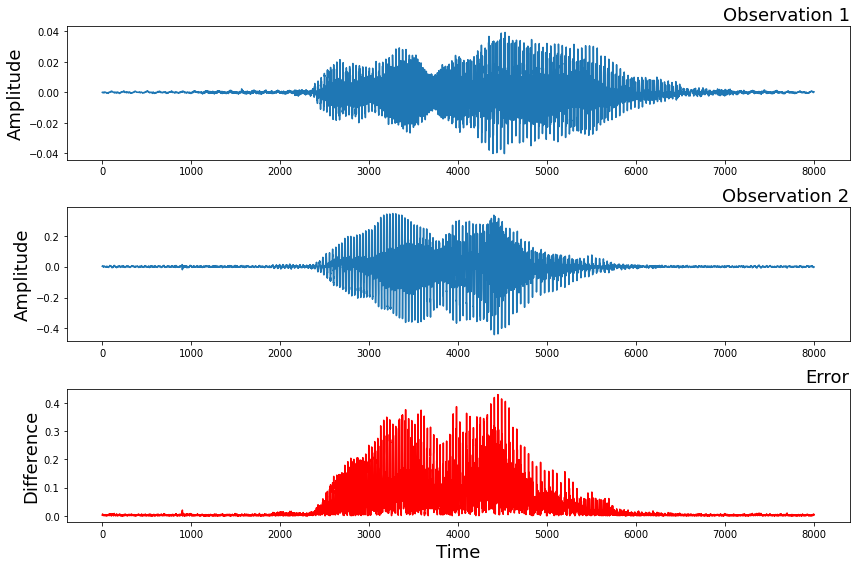

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa

mdf = pd.read_csv('metadata.csv')
zeroes = mdf[mdf.digit == 'zero']
obs1, sr = librosa.load(zeroes.iloc[0]['filename'], sr=8000)
obs2, sr = librosa.load(zeroes.iloc[1]['filename'], sr=8000)
obs_diff = abs(obs2 - obs1)

fig, (wav1, wav2, wav3) = plt.subplots(3, 1, figsize=(12,8))

wav1.plot(obs1)
wav1.set_ylabel('Amplitude', fontsize=18)
wav1.set_title('Observation 1', fontsize=18, loc='right')

wav2.plot(obs2)
wav2.set_ylabel('Amplitude', fontsize=18)
wav2.set_title('Observation 2', fontsize=18, loc='right')

wav3.plot(obs_diff, color='red')
wav3.set_xlabel('Time', fontsize=18)
wav3.set_ylabel('Difference', fontsize=18)
wav3.set_title('Error', fontsize=18, loc='right')

plt.tight_layout()

We're looking at the <i>waveform</i> of Observation 1 and Observation 2 above. The waveform plots the amplitude of each sample as a function of time. 

We can see that Observation 1 and Observation 2 have the same general shape––two large "clusters" of sound with a slight narrowing in the middle)––and even start at almost exactly the same time. The red plot at the bottom represents the error between the raw data in the two signals. The higher the value, the more different the two observations were at that point. This is typical with audio data (and speech data in particular) for a variety of reasons: background noises, accents, the speaker in Observation 2 speaking faster than the speaker in Observation 1, and so on.

This means we need to be more sophisticated in our approach.

## Fourier Transforms

Fourier transforms allow us to analyze data in small chunks, and to aggregate individual samples with the neighboring samples to extract properties.

A common approach to working with audio data is to divide the data into $n$ small, overlapping windows and perform a <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform">Fast Fourier Transform</a> on each of those windows. This process is called the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">Short Time Fourier Transform</a>.

<a href="https://www.youtube.com/watch?v=T9x2rvdhaIE">Great explanation by Mike X Cohen</a>.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa

mdf = pd.read_csv('metadata.csv')
zeroes = mdf[mdf.digit == 'zero']

# read in two files at a rate of 8000 Hz
obs1, sr = librosa.load(path=zeroes.iloc[0]['filename'], sr=8000)
obs2, sr = librosa.load(path=zeroes.iloc[1]['filename'], sr=8000)

obs1_stft = librosa.stft(y=obs1) # obs1_stft is a complex-valued array
obs2_stft = librosa.stft(y=obs2) # obs2_stft is a complex-valued array

print('Shape of obs1_stft (post short-time Fourier Transform):')
print(obs1_stft.shape[1], 'windows and', obs1_stft.shape[0], 'frequency bins')
# 16 windows and 1025 frequency bins

print('\nIndividual entries are complex-values (first two entries in first five rows shown):')
for obs in enumerate(obs1_stft[:5]):
    print(obs[0], obs[1][:2])
    
# convert to real number by taking the modulus of each entry
abs1 = abs(obs1_stft)
abs2 = abs(obs2_stft)

print('\nAbsolute values of observations, post-stft:')
for obs in enumerate(abs1[:5]):
    print(obs[0], obs[1][:2])
    
# preview of averaged data
# turns 1025 x 16 array into 1025 x 1 array of real numbers, which
# reduces the number of inputs to about 1/8 of the raw data
mean1 = abs(librosa.stft(obs1)).mean(axis=1)
print('Shape:', mean1.shape, '\n')
print(mean1)

As you can see above, librosa's stft function returns a complex-valued array, so we convert these complex numbers into real numbers by taking the absolute value: $|(a + bi)| = \sqrt{a^2 + b^2}$.

We'll see that this doesn't actually decrease the amount of values per observation––in fact, it increases it from 8000 to $1025 \times 16 = 16400$ values.

We'll look at two options for dealing with this: 
1. <b>Averaging across rows:</b> Each row represents a frequency bin, so this gives us the average "activity" of that frequency throughout the entire recording, without reference to when that bin was active. This approach is less sensitive to differences in speaker speed and pauses, but is more sensitive to the speaker's pitch (<a href="https://en.wikipedia.org/wiki/Voice_frequency">deep voices correspond to low frequencies, high voices correspond to higher frequencies</a>). 
2. <b>Averaging across columns:</b> Each column represents a window of time, so this gives us an idea of what the average frequency was within each window, but does not tell us about the distribution of those frequencies. This approach is very sensitive to speed, pauses, and delays, and I'm only providing it for comparison.

Let's bundle this into a function that works like load_raw_data, but each row is the mean absolute value stft for that frequency bin.

In [ ]:
import tqdm, librosa
import numpy as np
import data_loader
split_metadata = data_loader.split_metadata

def load_stft_data(digits=['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'], 
                   test_size=0.2, 
                   random_state=0,
                   only_train=False,
                   shuffle=True,
                   mean_of='freq'):
    """
    Samples data at 8000 Hz, then performs the following transformations:
    
    1. Computes the stft, converting the raw 8000x1 array into a 1025x16 array
    2. Takes the absolute value of each entry to convert complex numbers to real numbers.
    3. Takes the average of each frequency bin to remove time and reduce dimensionality.
       This converts each observation into a 1025x1 array.
    
    Only loads data for the classes specified in the digits parameter. Must contain
    at least one of the values from the default list, or a ValueError will be thrown. As long
    as there is at least one valid value, all invalid values will be ignored. Default
    loads all ten classes.
    
    Loads each file using the filename in the training metadata and test metadata, then recompiles
    it into a DataFrame with the original index.
    
    This function also provides an option for loading only the training data (which will be
    cross-validated in each epoch of the neural network).
    
    ==========================================================================================
    
    Parameters
    ----------
    digits (list-like):
        A list of digits to include in the train/test/split data. All valid digits are
        included in the default list.
        Default: ['zero', 'one', 'two', 'three', 'four', 
                  'five', 'six', 'seven', 'eight', 'nine']
        
    test_size (float):
        Specifies the proportion of the data to put in the 'test' list. Passed directly to
        train_test_split. 
        Default: 0.2
    
    random_state (int):
        A seed for the random number generator. Passed directly to train_test_split. 
        Default: 0
        
    only_train (bool):
        If this is selected, only the training data is loaded. Accuracy is measured with
        cross-validation at the end of each epoch.
        Default: False
        
    shuffle (bool):
        Whether to shuffle the data before splitting into training and test sets. 
        Default: True
        
    mean_of (str):
        Whether to take the mean of each frequency bin or of each time window.
        Acceptable values are 'freq' and 'time.' (Defaults to 'freq' if the input
        is not understood.)
        Default: 'freq'
        
    ==========================================================================================
        
    Returns
    -------
    X_train (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
    
    X_test (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
        
    y_train (pandas.core.frame.DataFrame):
        One-hotted classes for the training data. Index is id, each column is a digit.
        Column order is arbitrary. Represents 100 * (1-test_size)% of the data.
        
    y_test (pandas.core.frame.DataFrame):
        One-hotted classes for the test data. Index is id, each column is a digit.
        Columnn order is arbitrary. Represents 100 * test_size% of the data.  
    """
    print('Loading stft data...')
    
    X_train = dict()
    X_test = dict()
    
    # a variable that determines which axis to take the 
    mean_axis = 0 if mean_of == 'time' else 1
    
    print('Loading metadata...')
    X_train_md, X_test_md, y_train, y_test = split_metadata(digits=digits, 
                                                            test_size=test_size, 
                                                            random_state=random_state, 
                                                            shuffle=shuffle) 
    
    # regardless of the value of only_train, we need to load the training data
    print('Computing mean of stfts by {}...'.format(mean_of))
    for uid_train in tqdm.tqdm(X_train_md.index, desc='loading training data'):
        train_obs, sr = librosa.load(X_train_md.loc[uid_train], sr=8000)
        X_train[uid_train] = abs(librosa.stft(train_obs)).mean(axis=mean_axis).T
    
    print('Constructing training DataFrame... this might take a few minutes')
    X_train = pd.DataFrame.from_dict(X_train, orient='index')

    # if only_train is True, we can speed things up by not loading the test data
    if only_train == True:
        return X_train, y_train
    
    else: # otherwise, we need to load the test data
        print('Loading raw test data from wav files...')
        for uid_test in tqdm.tqdm(X_test_md.index, desc='    loading test data'):
            test_obs, sr = librosa.load(X_test_md.loc[uid_test], sr=8000)
            X_test[uid_train] = abs(librosa.stft(test_obs)).mean(axis=mean_axis).T
        
        print('Constructing test DataFrame...')
        X_test = pd.DataFrame.from_dict(X_test, orient='index')
        return X_train, X_test, y_train, y_test

Let's try the same neural network architecture, but on this new STFT data (with 1025 inputs instead of 8000).

In [ ]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
import data_loader

# comment out this cell if you've loaded training/test data elsewhere
X_train, y_train = data_loader.load_stft_data(only_train=True)

model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=1025))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train.values, y_train,
                    epochs=50,
                    batch_size=16, # for speed
                    validation_split=0.1)

plt.figure(figsize=(9, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9, xmin=0, xmax=1, c='r', ls='--')
plt.title('Learning Progress', fontsize=24)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=18)
plt.legend(['accuracy', 'val_accuracy']);

loading training data:   0%|          | 0/17249 [00:00<?, ?it/s]

Loading stft data...
Loading metadata...
Reading metadata from metadata.csv
Subsetting to ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
Subsetting for uniform length...
Keeping only the filename...
One-hot encoding the target variable...
Computing mean of stfts by freq...


loading training data:  22%|██▏       | 3758/17249 [00:57<03:24, 65.93it/s]

In [ ]:
# pickle the history so we can compare models without running them again
# this has already been done.

#import pickle

#with open('history/history_stft.pickle', 'wb') as handle:
#    pickle.dump(history.history, handle)

## Analysis of same model with STFT instead of raw data

As can be seen in the output above, we get massive leaps forward in accuracy when training on the mean absolute value of the STFTs. On the raw data, the validation accuracy was about 18%, but after our transformation, we've increased that validation accuracy to about 66%.

This should make sense. Separating the data into frequency bins and looking at windows instead of observations allows us to group similar observations together. As we can see below, comparing our two recordings of "zero", the two plots have very similar shapes, albeit different frequencies. Note that I've normalized the means, in order to account for the fact that one of the recordings was louder than the other.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa

mdf = pd.read_csv('metadata.csv')
zeroes = mdf[mdf.digit == 'zero']
sixes = mdf[mdf.digit == 'six']
obs0a, sr = librosa.load(zeroes.iloc[0]['filename'], sr=8000)
obs0b, sr = librosa.load(zeroes.iloc[1]['filename'], sr=8000)

obs6a, sr = librosa.load(sixes.iloc[0]['filename'], sr=8000)
obs6b, sr = librosa.load(sixes.iloc[1]['filename'], sr=8000)

mean0a = abs(librosa.stft(obs0a)).mean(axis=1)
mean0b = abs(librosa.stft(obs0b)).mean(axis=1)
mean6a = abs(librosa.stft(obs6a)).mean(axis=1)
mean6b = abs(librosa.stft(obs6b)).mean(axis=1)

fig, ((ax0a, ax6a), (ax0b, ax6b)) = plt.subplots(2, 2, figsize=(16,9))
ax0a.plot(mean0a/mean0a.mean())
ax0a.set_ylabel('Prevalence', fontsize=18)
ax0a.set_title('"Zero" A')

ax6a.plot(mean6a/mean6a.mean())
ax6a.set_title('"Six" A')

ax0b.plot(mean0b/mean0b.mean())
ax0b.set_ylabel('Prevalence', fontsize=18)
ax0b.set_xlabel('Frequency Bin', fontsize=18)
ax0b.set_title('"Zero" B')

ax6b.plot(mean6b/mean6b.mean())
ax6b.set_title('"Six" B')
ax6b.set_xlabel('Frequency Bin', fontsize=18)

plt.suptitle('Comparison of recordings in Frequency Domain ("zero" vs. "six")', fontsize=24)
plt.xlabel('Frequency Bin', fontsize=18)
plt.tight_layout()

We can see that the two recordings seem to have similar active frequency bins throughout their durations, but the sheer number of bins increases the variation too much to be useful.

## MFCCs

Over <a href="https://link.springer.com/article/10.3758/s13423-016-1130-6">hundreds of thousands of years of evolution</a>, our speech patterns and hearing capabilities have optimized each other, so the best way to parse human language in an audio recording is to mimic the way our brain parses it.

Computing the <a href="https://en.wikipedia.org/wiki/Mel-frequency_cepstrum">Mel-frequency cepstral coefficients</a> for each observation takes binning to the next level, but dividing not into equally-spaced frequency bins (like the STFT), but bins that reflect the frequency bands that humans are best at understanding. Here is a great explanation of how the MFCCs extract speech features by <a href="https://www.researchgate.net/post/Why_we_take_only_12-13_MFCC_coefficients_in_feature_extraction">Amir Hossein Poorjam</a>.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa

mdf = pd.read_csv('metadata.csv')
zeroes = mdf[mdf.digit == 'zero']

# read in two files at a rate of 8000 Hz
obs1, sr = librosa.load(path=zeroes.iloc[0]['filename'], sr=8000)
obs2, sr = librosa.load(path=zeroes.iloc[1]['filename'], sr=8000)

obs1_mfcc = librosa.feature.mfcc(y=obs1) # obs1_stft is a complex-valued array
obs2_mfcc = librosa.feature.mfcc(y=obs2) # obs2_stft is a complex-valued array

print('Shape of obs1_mfcc (post short-time Fourier Transform):')
print(obs1_mfcc.shape[1], 'windows and', obs1_mfcc.shape[0], 'frequency bins')
# 16 windows and 1025 frequency bins

print('\nIndividual entries are real-valued:')
for obs in enumerate(obs1_mfcc[:5]):
    print(obs[0], obs[1][:5])

cmap_name='Spectral'
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(obs1_mfcc, cmap=plt.get_cmap(cmap_name))
ax1.set_title('Observation 1')
ax2.imshow(obs2_mfcc, cmap=plt.get_cmap(cmap_name));
ax2.set_title('Observation 2');

Despite the differences in intensity, there are a few features that are now obviously popping out. 

We can see a light section from about (6, 2.0) to (12, 2.0) on both images, a dark bar from (6, 5.0) to (12, 5.0), and a darker diagonal pattern on top of a lighter diagonal pattern from (4, 11) to (10, 15). Although these aren't technical terms, similar patterns in the images of the MFCCs correspond to similar frequencies being active at similar times, which is exactly what we're looking for.

But first, a function to compute the MFCCs for us. We'll need to modify our approach from before to eliminate the intermediate trip through the pandas DataFrame––I did this initially to ensure that training data and labels lined up on their unique identifiers, but now we're going to have to trust that no reordering will take place between splitting and evaluating our loss function.

In [6]:
import tqdm, librosa
import numpy as np
import data_loader
split_metadata = data_loader.split_metadata

def load_mfcc_data(digits=['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'], 
                   test_size=0.2, 
                   random_state=0,
                   only_train=False,
                   shuffle=True):
    """
    Samples data at 8000 Hz, then uses librosa's mfcc function to extract the
    Mel-frequency ceptstral coefficients (MFCCs).
    
    Only loads data for the classes specified in the digits parameter. Must contain
    at least one of the values from the default list, or a ValueError will be thrown. As long
    as there is at least one valid value, all invalid values will be ignored. Default
    loads all ten classes.
    
    Loads each file using the filename in the training metadata and test metadata, then recompiles
    it into a DataFrame with the original index.
    
    This function also provides an option for loading only the training data (which will be
    cross-validated in each epoch of the neural network).
    
    ==========================================================================================
    
    Parameters
    ----------
    digits (list-like):
        A list of digits to include in the train/test/split data. All valid digits are
        included in the default list.
        Default: ['zero', 'one', 'two', 'three', 'four', 
                  'five', 'six', 'seven', 'eight', 'nine']
        
    test_size (float):
        Specifies the proportion of the data to put in the 'test' list. Passed directly to
        train_test_split. 
        Default: 0.2
    
    random_state (int):
        A seed for the random number generator. Passed directly to train_test_split. 
        Default: 0
        
    only_train (bool):
        If this is selected, only the training data is loaded. Accuracy is measured with
        cross-validation at the end of each epoch.
        Default: False
        
    shuffle (bool):
        Whether to shuffle the data before splitting into training and test sets. 
        Default: True
        
    ==========================================================================================
        
    Returns
    -------
    X_train (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
    
    X_test (pandas.core.frame.DataFrame):
        DataFrame will vary in number of rows, depending on which digit classes are subset 
        and what the training/test size is.
        
        Has 8000 columns (0-7999), representing the sequence of samples taken.
        
        Index is the unique id given to each recording (order should be preserved)
        
    y_train (pandas.core.frame.DataFrame):
        One-hotted classes for the training data. Index is id, each column is a digit.
        Column order is arbitrary. Represents 100 * (1-test_size)% of the data.
        
    y_test (pandas.core.frame.DataFrame):
        One-hotted classes for the test data. Index is id, each column is a digit.
        Columnn order is arbitrary. Represents 100 * test_size% of the data.  
    """
    print('Loading MFCC data...')
    
    X_train = []
    X_test = []
    
    print('Loading metadata...')
    X_train_md, X_test_md, y_train, y_test = split_metadata(digits=digits, 
                                                            test_size=test_size, 
                                                            random_state=random_state, 
                                                            shuffle=shuffle) 
    
    # regardless of the value of only_train, we need to load the training data
    print('Computing mfccs...')
    for uid_train in tqdm.tqdm(X_train_md.index, desc='loading training data'):
        train_obs, sr = librosa.load(X_train_md.loc[uid_train], sr=8000)
        X_train.append(librosa.feature.mfcc(train_obs))
    
    print('Converting training data to numpy array...')
    X_train = np.array(X_train)

    # if only_train is True, we can speed things up by not loading the test data
    if only_train == True:
        return X_train, y_train
    
    else: # otherwise, we need to load the test data
        print('Loading raw test data from wav files...')
        for uid_test in tqdm.tqdm(X_test_md.index, desc='    loading test data'):
            test_obs, sr = librosa.load(X_test_md.loc[uid_test], sr=8000)
            X_test.append(librosa.feature.mfcc(test_obs))
        
        print('Converting test data to numpy array...')
        X_test = np.array(X_test)
        return X_train, X_test, y_train, y_test

In [2]:
# note the shape of the outputs now
# variable names changed to prevent leakage across cells
import data_loader

xtr, xts, ytr, yts = data_loader.load_mfcc_data(['one', 'two'])

print('Shape of training data:', xtr.shape)
print('Shape of test data:', xts.shape)

loading training data:   0%|          | 6/3394 [00:00<01:05, 51.82it/s]

Loading stft data...
Loading metadata...
Reading metadata from metadata.csv
Subsetting to ['one', 'two']
Subsetting for uniform length...
Keeping only the filename...
One-hot encoding the target variable...
Computing mfccs...


    loading test data:   1%|          | 6/849 [00:00<00:15, 53.30it/s]

Converting training data to numpy array...
Loading raw test data from wav files...


    loading test data: 100%|██████████| 849/849 [00:15<00:00, 56.30it/s]

Converting test data to numpy array...
Shape of training data: (3394, 20, 16)
Shape of test data: (849, 20, 16)


For comparison, let's pass these shiny new inputs into the same network structure we used with the other inputs. We'll need to reshape our data into a single row of 320 values first.

loading training data:   0%|          | 5/17249 [00:00<06:10, 46.51it/s]

Loading MFCC data...
Loading metadata...
Reading metadata from metadata.csv
Subsetting to ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
Subsetting for uniform length...
Keeping only the filename...
One-hot encoding the target variable...
Computing mfccs...


loading training data: 100%|██████████| 17249/17249 [05:09<00:00, 55.68it/s]


Converting training data to numpy array...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               82176     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 84,746
Trainable params: 84,746
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
971/971 [==============================] - 1s 761us/step - loss: 11.0978 - accuracy: 0.5014 - val_loss: 5.0202 - val_accuracy: 0.6446
Epoch 2/50
971/971 [==============================] - 1s 763us/step - loss: 3.6470 - accuracy: 0.6837 - val_loss: 2.9266 - val_accuracy: 0.6690
Epoch 3/50
971/971 [==============================] - 1s 703us/step - loss: 1.8986 - accuracy: 0.7494 - val_loss: 1.5243 - val_accuracy: 0.7617
Epoch 4/50
971/971 [================

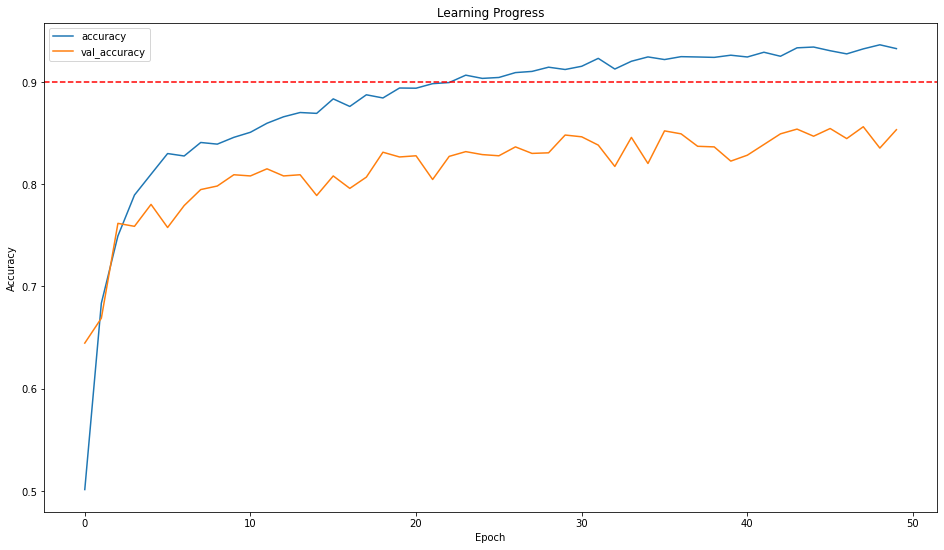

In [4]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
import data_loader

X_train, y_train = data_loader.load_mfcc_data(only_train=True)

X_train_reshaped = X_train.reshape(len(X_train), -1)

model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=(X_train_reshaped.shape[1])))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.1)

plt.figure(figsize=(16, 9))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9, xmin=0, xmax=1, c='r', ls='--')
plt.title('Learning Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy']);

In [ ]:
# this cell does not need to be run; it is only included for documentation purposes
#import pickle

#with open('history/history_mfcc_dff.pickle', 'wb') as handle:
#    pickle.dump(history.history, handle)

As we can see, using flattened MFCCs instead of the raw STFT data increases our validation accuracy from around 67% to about 84%. MFCCs are clearly the way to go.

Fortunately, these individual observations are fairly small, so we can keep them in 2D. This provides justification for moving from our "vanilla" neural network to a <a href="https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363">convolutional neural network (CNN)</a>.

That said, in the post-mvp notebook, we'll play around with other architectures to see if we can raise this score

## Convolutional Neural Network trained on MFCCs

Although we've seen great leaps in accuracy just by training our simple DFF on MFCCs (320 inputs) instead of raw data (8000) inputs, we have a good reason to move on to a CNN. Primarily, our MFCCs consist of both neighboring bands of frequencies and neighboring windows of time. Identical pronunciation but different deepness of voice would produce similar shapes of data, but in slightly different frequency bins. A CNN will take this into account by training the filters on neighboring observations as well as individual observations.

The only change we're going to make is adding in a single Conv1D layer with 32 3x3 filters, followed by a flattening layer so we can pass it into the same Dense layer we've been using for the other models.

loading training data:   0%|          | 5/17249 [00:00<06:11, 46.43it/s]

Loading MFCC data...
Loading metadata...
Reading metadata from metadata.csv
Subsetting to ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
Subsetting for uniform length...
Keeping only the filename...
One-hot encoding the target variable...
Computing mfccs...


    loading test data:   0%|          | 5/4313 [00:00<01:32, 46.55it/s]

Converting training data to numpy array...
Loading raw test data from wav files...


    loading test data: 100%|██████████| 4313/4313 [01:19<00:00, 53.99it/s]


Converting test data to numpy array...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 32)            1568      
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               147712    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 151,850
Trainable params: 151,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
971/971 - 1s - loss: 3.0094 - accuracy: 0.5959 - val_loss: 0.8358 - val_accuracy: 0.7386
Epoch 2/50
971/971 - 1s - loss: 0.6536 - accuracy: 0.8045 - val_loss: 0.6304 - val_accuracy: 0.7977
Epoch 3

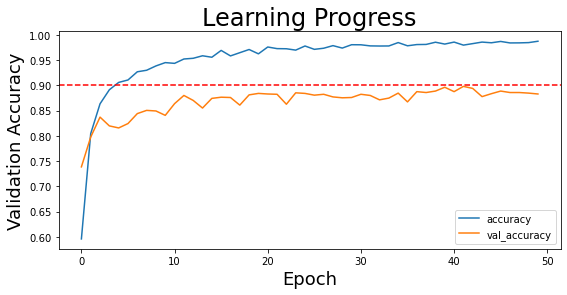

In [6]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras import regularizers
import tensorflow as tf
import data_loader

# comment out this cell if you've loaded training/test data elsewhere
X_train, X_test, y_train, y_test = data_loader.load_mfcc_data()

model = Sequential()
model.add(Conv1D(filters=32, 
                 kernel_size=3, 
                 activation='relu', 
                 input_shape=X_train[0].shape))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.1,
                    use_multiprocessing=True,
                    verbose=2)

score=model.evaluate(X_test, y_test, batch_size=1)
print('\nAccuracy (Test data):', score[1])

plt.figure(figsize=(9, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9, xmin=0, xmax=1, c='r', ls='--')
plt.title('Learning Progress', fontsize=24)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=18)
plt.legend(['accuracy', 'val_accuracy']);

In [ ]:
# this cell does not need to be run; it is only included for documentation purposes
#import pickle

#with open('history/history_mfcc_cnn.pickle', 'wb') as handle:
#    pickle.dump(history.history, handle)

## Comparison of Models

As we can see by the accuracy score above (about 87% on <b>test</b> data, in addition to validation data), adding in the convolutional layer does indeed help. Now that we've run all of our models, we can directly compare them to each other.

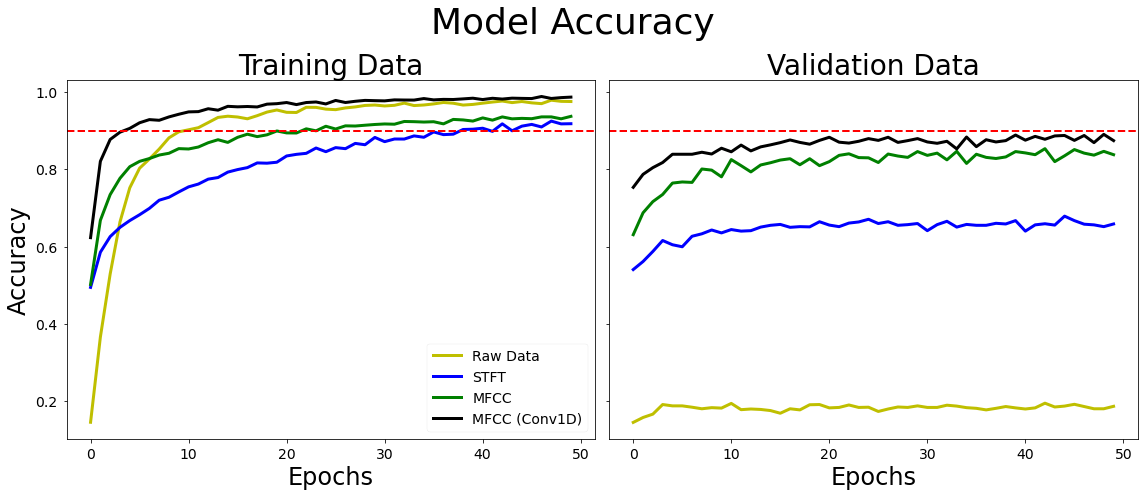

In [2]:
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

with open('history/history_raw.pickle', 'rb') as handle:
    raw = pickle.load(handle)
    
with open('history/history_stft.pickle', 'rb') as handle:
    stft = pickle.load(handle)
    
with open('history/history_mfcc_dff.pickle', 'rb') as handle:
    mfcc_dff = pickle.load(handle)
    
with open('history/history_mfcc_cnn.pickle', 'rb') as handle:
    mfcc_cnn = pickle.load(handle)

fig, (acc, val) = plt.subplots(1, 2, figsize=(16,7), sharey=True)

acc.plot(raw['accuracy'], c='y', lw=3)
acc.plot(stft['accuracy'], c='b', lw=3)
acc.plot(mfcc_dff['accuracy'], c='g', lw=3)
acc.plot(mfcc_cnn['accuracy'], c='k', lw=3)
acc.legend(['Raw Data', 'STFT', 'MFCC', 'MFCC (Conv1D)'], fontsize=14)
acc.set_xlabel('Epochs', fontsize=24)
acc.set_ylabel('Accuracy', fontsize=24)
acc.tick_params(labelsize=14)
acc.set_title('Training Data', fontsize=28)
acc.axhline(0.9, xmin=0, xmax=1, c='r', lw=2, ls='--')

val.plot(raw['val_accuracy'], c='y', lw=3)
val.plot(stft['val_accuracy'], c='b', lw=3)
val.plot(mfcc_dff['val_accuracy'], c='g', lw=3)
val.plot(mfcc_cnn['val_accuracy'], c='k', lw=3)
val.set_xlabel('Epochs', fontsize=24)
val.tick_params(labelsize=14)
val.set_title('Validation Data', fontsize=28)
val.axhline(0.9, xmin=0, xmax=1, c='r', lw=2, ls='--')

plt.suptitle('Model Accuracy', fontsize=36)
plt.savefig('whatever.png')
plt.tight_layout();

The graph above displays the accuracy scores for the validation data for each of the four models, with 0.9 (90%) plotted as a dashed line for reference. We can see from the plot on the right that, as is expected without regularization, all models overfit the data to some degree, eventually breaking 90% accuracy on the training data. 

The most egregious overfitting occurs with the raw data (in (red), which quickly breaks 90% accuracy on training data but does not gain any traction with the validation data, confirming our initial assessment of raw audio data as a very poor input for a neural network.

Clearly, the top choice here is training on MFCCs with at least one convolutional layer in the network (black), as it outperforms the other architectures at every epoch. That said, there may be an architecture in which the flattened MFCCs (green) without a convolutional layer could outperform the CNN, as the validation accuracy––further exploration is needed to determine whether it was the additional <i>convolutional</i> layer that gave this model the edge, or if it was simply the added <i>depth</i> that comes with any additional layer. This is a question I will explore in another (post-MVP) notebook.

## Next Steps

Further analysis is obviously needed beyond this point. While increases in validation accuracy are a helpful metric to consider, an accuracy rate close to 90% does not tell us the complete story; we don't know whether that 90% accuracy rate is coming from 10% error in all ten classes, or if we have nine classes with 100% accuracy and one class with 0% accuracy.

It would also be helpful to increase the training data for the digit corresponding to the ground floor (likely, "one") because every person using the elevator to exit the building will go to that floor, while the only people hitting floor "four" will be people who are going to an apartment or office on that floor.

In addition to analyzing the results more, we'll want to do some more extensive preprocessing on the data. <b>Noise floor detection</b> will set a minimum threshold for sound information to be considered "relevant" to our classification problem, under the assumption that the speech sounds made by the user close to the microphone are louder and more important than faint background noises. After filtering out the faint noises, it will also make sense to remove the dead space from the recordings.

# Summary

### Deployment

One implementation (further development, beyond this MVP) would include both a <a href="https://www.amazon.com/gp/product/B01MQ2AA0X/ref=ppx_yo_dt_b_asin_title_o00_s00?ie=UTF8&psc=1">microphone</a> for user input and a motion sensor or <a href="https://www.mouser.com/ProductDetail/Parallax/28015?qs=Re%252Bcz0%2FMYCKqvqZW3g9mzg%3D%3D&gclid=Cj0KCQjws536BRDTARIsANeUZ58w_2FTLF44Sx-TcCKhdPaix5n7f6qUxFhfMzfhaCgmng8_pAnR4EMaAktKEALw_wcB">proximity sensor</a>. The user waves their hand in front of the proximity sensor to trigger the microcontroller's recording function, then speaks a string of digits "zero" through "nine" into the microphone within a short window of time. The digits are extracted individually, converted into a string of digits, and this command is passed to the elevator controller. 

The microcontroller then moves into a "confirmation phase," in which it communicates the string of digits back to the user (either by displaying it on a panel or playing audio recordings of the desired floor's digits), and prompts the user to respond with "yes" or "no" if the information is correct. If the information is correct, the elevator controller moves the elevator to the desired floor. If the information is not correct, the user has the option to restart the process by activating the proximity sensor or override the choice by pressing the (still-functional) buttons.

A sign could be posted next to the unit with instructions displayed both in writing and via graphics.

<b>VOICE CONTROL</b>
    
* WAVE HAND IN FRONT OF DEVICE TO ACTIVATE

* SPEAK SINGLE DIGITS (ex. ONE TWO for 12)

* DEVICE WILL ASK IF FLOOR IS CORRECT

* RESPOND WITH "YES" OR "NO"

One of the benefits of using a speech recognition system is that they are already widespread enough that most people have an intuition for how they work and how to interact with them. A benefit of <i>this</i> speech recognition model is that it is tailored to this specific purpose, lightweight enough for deployment on microcontrollers such as the Raspberry Pi, and open-source, for customization and modification.

### Effects and Limitations

While the goal of this system is to <i>reduce</i> physical interactions with elevator buttons in order to prevent community spread, it is worth noting that it can not <i>eliminate</i> the physical interactions entirely. People with speech difficulties, language barriers, or strong accents that are not reflected in the training data may not be able to successfully interact with the device, which would necessitate the use of the physical buttons. Additionally, malfunctioning units (such as a faulty microphone or proximity detector) may need to revert back to the old, physical-control scheme.

### Ethics

With any speech recognition system, there are <a href="https://blog.einstein.ai/why-ethics-is-priority-one-for-making-voice-assistants-work-in-the-enterprise/">ethical concerns</a> that must be taken into consideration:

1. <b>Consent:</b> Users would be strongly encouraged, but not required, to use the voice-operated functionality to travel between floors. Risk of community transmission via physical contact with buttons should be prominently displayed, but existing buttons should remain operational.

2. <b>Accuracy and Accessibility:</b> This model should be trained on a larger collection of recordings featuring wider variety of pronunciations in order to make voice control accessible to a wider array of users.

3. <b>Privacy:</b> Deploying the minimal model (ten digits, two confirmation words) would allow the speech controllers to be completely self-contained and isolated. Furthermore, user data would only be recorded when the device is triggered (via the proximity sensor), a minimal amount of data would be collected (long enough to speak the floor number as a string of digits), and audio recordings would be held in memory long enough for digit extraction and classification. Outside of the device's communication with the elevator controller, no user data would be transmitted outside of the voice control unit.